In [29]:
import sys
import torch

seed = 42
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from modules.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from modules.IO.LibraryLoader import LibraryLoader
from modules.MOL.FragmentationTree import FragmentationTree 
from modules.visualization.define_colors import set_light_theme
from modules.visualization.define_colors import *
set_light_theme()
import modules.visualization.spectrum_visualizer as sv


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


Working with Python 3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


## Data

In [30]:
def read_log(file):
    LOG = pd.read_csv(file, sep="\t")
    eval_columns = LOG.columns[3:]

    for col in eval_columns:
        LOG[col] = LOG[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    return LOG

In [31]:
path = f"{home}/data/metabolites/benchmarking/"
NAMES = ["GraphConv_depth.csv", "RGCNConv_depth.csv", "CGConv_depth.csv", "GAT_depth.csv", "TransformerConv_depth.csv"]

log = []
for name in NAMES:
    new_log = read_log(path + name)
    log.append(new_log)

log = pd.concat(log, ignore_index=True)

In [32]:
log


,depth,gnn_type,model,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,0,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.6934386179140075, 0.6203799882162216, 0.517...","[0.6941390043726501, 0.8245588022913074, 0.649...","[0.718022067763872, 0.6093000329182957, 0.7488...","[0.24536000062643326, 0.16269399569101828, 0.0...","[0.7719657279166581, 0.9680720737774142, 0.887...","[0.718022067763872, 0.6093000329182957, 0.7488...","[0.24536000062643326, 0.16269399569101828, 0.0...","[0.6403012405125128, 0.530593694454641, 0.2360..."
1,1,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.8984809592929622, 0.8480900817053835, 0.761...","[0.7975303897993268, 0.8339816344338022, 0.786...","[0.8814018891330726, 0.7378121380510613, 0.886...","[0.3557075569647889, 0.2240010685307835, 0.111...","[0.7510695752466574, 0.9737239474724141, 0.882...","[0.8814018891330726, 0.7378121380510613, 0.886...","[0.3557075569647889, 0.2240010685307835, 0.111...","[0.8791978119804579, 0.819752437673262, 0.3656..."
2,2,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.9369881352487537, 0.9039219716676336, 0.839...","[0.6761795237850038, 0.8026033192915121, 0.631...","[0.8929726765368401, 0.7418304649871578, 0.920...","[0.3685790248051129, 0.22111315970940465, 0.11...","[0.7878056601050538, 0.9768752879578148, 0.924...","[0.8929726765368401, 0.7418304649871579, 0.920...","[0.3685790248051129, 0.22111315970940465, 0.11...","[0.8962397116583926, 0.8116323747113573, 0.335..."
3,3,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.9479149807072119, 0.8796703998806358, 0.770...","[0.6743597853793898, 0.7934163988254798, 0.636...","[0.8842123805025082, 0.7446088486670595, 0.865...","[0.3888699106734758, 0.2396746622674266, 0.099...","[0.7477775197836017, 0.9841193511050734, 0.920...","[0.8842123805025082, 0.7446088486670595, 0.865...","[0.38886991067347587, 0.2396746622674266, 0.09...","[0.9327767209199324, 0.8393895252430161, 0.322..."
4,4,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.9044787460024586, 0.854930606706343, 0.7599...","[0.7131130150837951, 0.8326652960553556, 0.679...","[0.8607226015143673, 0.8256809998061808, 0.898...","[0.409427988253798, 0.21747995286531016, 0.056...","[0.834137612319943, 0.9546242219700963, 0.9168...","[0.8607226015143673, 0.8256809998061807, 0.898...","[0.40942798825379806, 0.21747995286531016, 0.0...","[0.9410113000400012, 0.8725888940548632, 0.358..."
5,5,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.9752564805579373, 0.9434954842506627, 0.877...","[0.7828806179371921, 0.8524873204821461, 0.757...","[0.8372787873617696, 0.7708571502628871, 0.920...","[0.3993717737383206, 0.20117465690712444, 0.06...","[0.7926200845035449, 0.9684969635316225, 0.925...","[0.8372787873617695, 0.7708571502628873, 0.920...","[0.3993717737383206, 0.20117465690712444, 0.06...","[0.9011588151706091, 0.81127658759816, 0.31097..."
6,6,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.9011926819308119, 0.8259669067693499, 0.687...","[0.7256165641416387, 0.8250260757263542, 0.696...","[0.7982232164023797, 0.8102360366229286, 0.866...","[0.3947014077587636, 0.197991454453552, 0.0897...","[0.8191250786189895, 0.9848439496861496, 0.767...","[0.7982232164023797, 0.8102360366229288, 0.866...","[0.39470140775876367, 0.197991454453552, 0.089...","[0.9363601685827381, 0.8814525017616385, 0.394..."
7,7,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.8422687655051956, 0.749808481767216, 0.6147...","[0.7239817094263415, 0.8143162402343055, 0.697...","[0.7911173603473218, 0.8185855242758692, 0.870...","[0.18104197132191815, 0.12353078842126215, 0.1...","[0.7394472684916048, 0.9418983274955394, 0.896...","[0.7911173603473218, 0.8185855242758692, 0.870...","[0.18104197132191815, 0.12353078842126215, 0.1...","[0.8804856933173792, 0.7949785141768203, 0.302..."
8,8,GraphConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"[0.75951481856

In [33]:
gnn_type_labels={"GraphConv": "GCN", "CGConv": "CGC", "GAT": "GAT", "RGCNConv": "RGCN", "TransformerConv": "Transformer"}

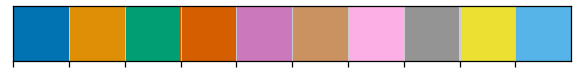

In [34]:
sns.palplot(sns.color_palette("colorblind"))
plt.show()

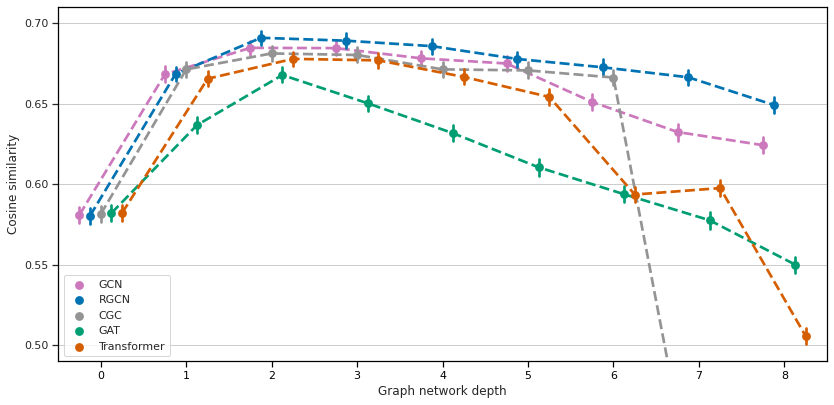

In [37]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

color_blind4=[sns.color_palette("colorblind")[4], sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[2], sns.color_palette("colorblind")[3]]
L = log.explode("validation")
L["gnn_type"] = L["gnn_type"].map(gnn_type_labels)
sns.pointplot(data=L, x="depth", y="validation", capsize=.0, markers="o", palette=color_blind4, markersize=4, errorbar=('ci', 0.95), linestyles='--', style="gnn_type", hue="gnn_type", dodge=0.5) # ci='sd',, palette=tri_palette,  bins=[x/10.0 for x in list(range(0,10,1))]), multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
#plt.ylim([0.4, 0.8])
plt.ylabel("Cosine similarity")
plt.xlabel("Graph network depth")
plt.yticks(np.arange(0.5, 0.71, 0.05))
# plt.autoscale(enable=True, axis='y')
plt.ylim(0.49, 0.71)
plt.legend(title="")


# fig.savefig(f"{home}/images/paper/grid_params2.svg", format="svg", dpi=600)
# fig.savefig(f"{home}/images/paper/grid_params2.png", format="png", dpi=600)
plt.show()

In [38]:
eval_columns = log.columns[3:]
log[log["gnn_type"] == "RGCNConv"][eval_columns].apply(lambda x: x.apply(np.mean) ,axis=1)

,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
9,0.580490,0.569829,0.568729,0.259554,0.542080,0.610512,0.253203,0.269446
10,0.668401,0.655627,0.644629,0.299647,0.617623,0.686972,0.300119,0.298913
11,0.690917,0.674403,0.663389,0.320273,0.636551,0.705469,0.317980,0.323844
12,0.689101,0.675186,0.662221,0.316510,0.627731,0.716297,0.309692,0.327127
13,0.685722,0.672232,0.656626,0.319179,0.624425,0.707114,0.312324,0.329854
14,0.677756,0.665433,0.653831,0.310446,0.627370,0.695319,0.307935,0.314356
15,0.672589,0.654477,0.641791,0.309364,0.617426,0.679992,0.304731,0.316581
16,0.666402,0.655298,0.644755,0.305814,0.609234,0.700449,0.301825,0.312026
17,0.649217,0.637870,0.636666,0.299693,0.608382,0.681013,0.301701,0.296566
